<a href="https://colab.research.google.com/github/dohyung-kim/ccri/blob/main/script/adm0/multi_hazards_stat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import glob
import os

In [2]:
data_dir = '/content/drive/MyDrive/CCRI_results_misc'
misc_dir = '/content/drive/MyDrive/misc'

In [3]:
ccri_json = gpd.read_file(os.path.join(data_dir,'p1_p2_avg_ccri.geojson'))

In [4]:
# Step 1: Read and merge region info
unicef_region = pd.read_csv(os.path.join(misc_dir, 'UNICEF_PROG_REG_GLOBAL.csv'))
ccri_json = ccri_json.merge(unicef_region,
                            left_on='ISO3', right_on='ISO3Code', how='left')

In [6]:



# Step 2: Read and merge hazard exposures
multi_hazards_files = glob.glob(os.path.join(data_dir, '*hazards.csv'))

all_hazards = None

for file in multi_hazards_files:
    suffix = file.split('/')[-1].replace('child_pop_exposed_', '').replace('.csv', '')
    df = pd.read_csv(file, usecols=['ISO3', 'sum']).rename(columns={'sum': f'{suffix}'})

    # Ensure ISO3 is clean
    df = df.dropna(subset=['ISO3'])
    df['ISO3'] = df['ISO3'].astype(str).str.strip()
    df = df.drop_duplicates(subset='ISO3')

    if all_hazards is None:
        all_hazards = df
    else:
        all_hazards = all_hazards.merge(df, on='ISO3', how='outer')




In [7]:
all_hazards

,ISO3,1_hazards,4_hazards,6_hazards,2_hazards,5_hazards,7_hazards,8_hazards,3_hazards,11_hazards,9_hazards,12_hazards,10_hazards,13_hazards,15_hazards,17_hazards,16_hazards,14_hazards
0,ABW,109.175040,3.110776e+03,0.000000e+00,1.426319e+03,0.000000e+00,0.000000e+00,0.000000,1.084592e+04,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,AFG,72493.731748,6.081742e+06,2.189718e+06,1.712548e+06,4.468730e+06,8.725180e+05,304391.948473,5.181844e+06,50.432964,64335.422501,0.0,1592.678227,0.0,0.0,0.0,0.0,0.0
2,AGO,478.631406,4.504224e+06,3.579647e+06,6.356068e+04,6.775651e+06,1.805051e+06,740252.110937,1.371400e+06,511.902217,125781.464001,0.0,10842.204828,0.0,0.0,0.0,0.0,0.0
3,AIA,0.000000,8.947860e+02,0.000000e+00,3.271701e+01,8.669050e-01,0.000000e+00,0.000000,1.256704e+03,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,ALA,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257,xSI,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
258,xSK,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
259,xSR,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
260,xUK,58.742646,1.324321e+03,0.000000e+00,8.339274e+02,2.328400e-02,0.000000e+00,0.000000,3.334236e+01,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


In [8]:
# Step 2: Merge with ccri_json once
ccri_json = ccri_json.merge(all_hazards, on='ISO3', how='left')



In [16]:
hazard_cols = [col for col in ccri_json.columns if col.endswith('_hazards')]

# Step 3: Calculate total exposed population per country
ccri_json['total_multi_hazard_exposed'] = ccri_json[hazard_cols].apply(pd.to_numeric, errors='coerce').sum(axis=1, skipna=True)

# Select hazard columns 4 and above
hazard_cols_4plus = [f"{i}_hazards" for i in range(4, 18)]  # 4 to 17

# Ensure all are numeric, then sum row-wise
ccri_json['exposed_to_4plus_hazards'] = (
    ccri_json[hazard_cols_4plus]
    .apply(pd.to_numeric, errors='coerce')
    .sum(axis=1, skipna=True)
)

# Step 4: Group by UNICEF region, excluding missing region values
region_summary = (
    ccri_json.dropna(subset=['Region'])  # Exclude rows with no region
             .groupby('Region')[hazard_cols + ['exposed_to_4plus_hazards']]
             .sum()
             .reset_index()
)


In [17]:
print(ccri_json[['ISO3', 'exposed_to_4plus_hazards']].head())


  ISO3  exposed_to_4plus_hazards
0  ATA                  0.000000
1  AIA                895.652900
2  ESH             117811.160653
3  PYF               6428.003507
4  PYF               6428.003507


In [25]:
np.sum(ccri_json['exposed_to_4plus_hazards'])

np.float64(1845077987.7200122)

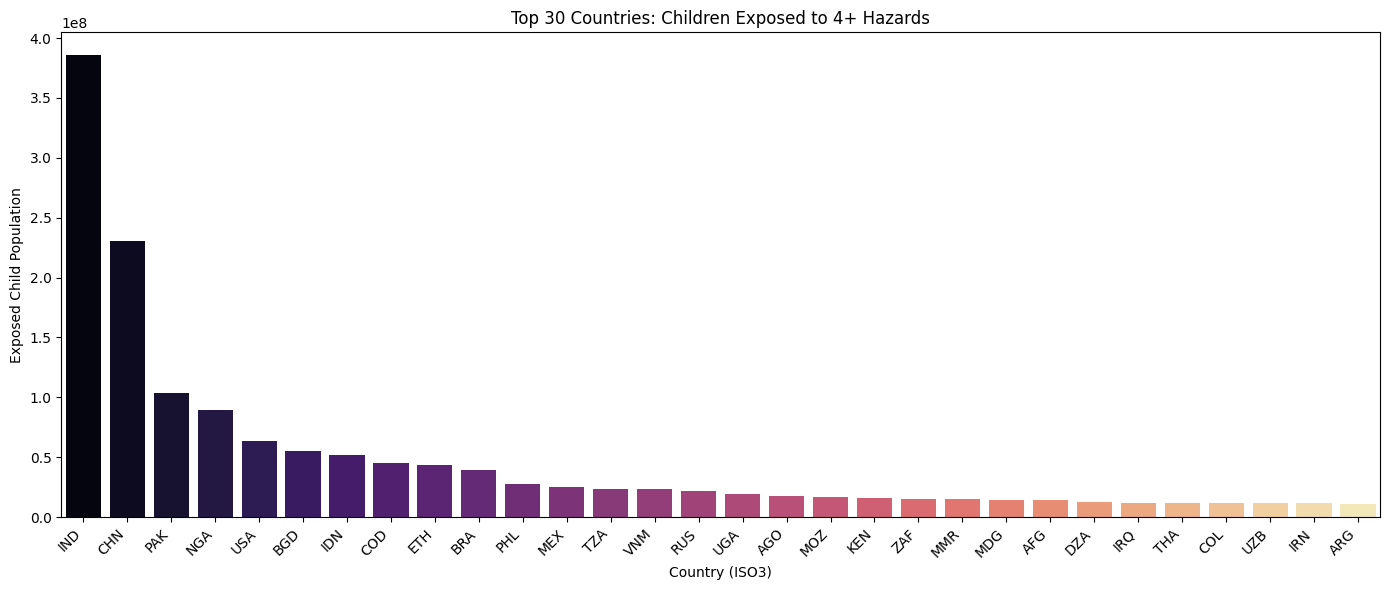

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare top 30 countries
plot_df = (
    ccri_json[['ISO3', 'exposed_to_4plus_hazards']]
    .copy()
    .dropna()
    .sort_values('exposed_to_4plus_hazards', ascending=False)
    .head(30)
)

plt.figure(figsize=(14, 6))
sns.barplot(
    data=plot_df,
    x='ISO3',
    y='exposed_to_4plus_hazards',
    hue='ISO3',
    palette='magma',
    legend=False
)

plt.xticks(rotation=45, ha='right')
plt.title('Top 30 Countries: Children Exposed to 4+ Hazards')
plt.ylabel('Exposed Child Population')
plt.xlabel('Country (ISO3)')
plt.tight_layout()
plt.show()


In [21]:
print(region_summary)

                            Region     1_hazards     4_hazards     6_hazards  \
0            East Asia and Pacific  5.614634e+06  1.401894e+08  6.873485e+07   
1      Eastern and Southern Africa  2.895157e+06  7.232656e+07  3.795453e+07   
2          Europe and Central Asia  4.654059e+06  1.650907e+07  8.602483e+06   
3  Latin America and the Caribbean  3.178832e+06  4.530381e+07  2.992039e+07   
4     Middle East and North Africa  4.730898e+06  3.276931e+07  1.385877e+07   
5                       South Asia  5.230754e+05  1.478953e+08  1.425064e+08   
6          West and Central Africa  6.520693e+05  9.860707e+07  3.531978e+07   

      2_hazards     5_hazards     7_hazards     8_hazards     3_hazards  \
0  2.366024e+07  1.368249e+08  2.744123e+07  7.853548e+06  7.048264e+07   
1  1.310011e+07  6.841910e+07  2.121786e+07  1.054340e+07  3.843209e+07   
2  1.073888e+07  1.877497e+07  1.760742e+06  3.303062e+05  1.350961e+07   
3  1.197510e+07  4.811389e+07  1.534145e+07  4.559265e+06  

In [26]:
np.sum(region_summary['exposed_to_4plus_hazards'])

np.float64(1666722706.5755177)

<ipython-input-24-7348793c5077>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


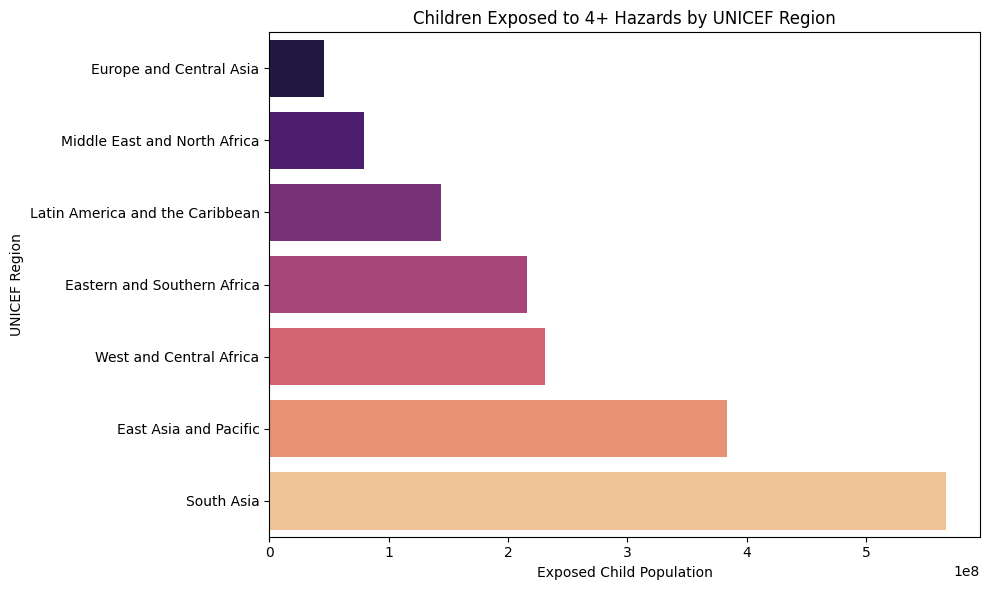

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sort for better visual
plot_df = region_summary.sort_values('exposed_to_4plus_hazards', ascending=True)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(
    data=plot_df,
    y='Region',
    x='exposed_to_4plus_hazards',
    palette='magma'
)

plt.title('Children Exposed to 4+ Hazards by UNICEF Region')
plt.xlabel('Exposed Child Population')
plt.ylabel('UNICEF Region')
plt.tight_layout()
plt.show()
